In [1]:
"""Modified_CNNDenoisingTutorial_MagiciansCorner.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1N8V56eHEx3uIWIahBvRGAorszAziyAs7

https://github.com/bnel1201/Ped-ETK

https://github.com/DIDSR/LCD_CT

Standard LCD Dataset: https://zenodo.org/record/7996580

Peds LCD Dataset: https://sandbox.zenodo.org/record/1213653

https://1drv.ms/w/s!AgJOdaganUhLjuldvIYTe20hA3Eyzw?e=6h7ZGM

# Convolutional Neural Network Denoising: Computed Tomography

"""

import urllib

import tensorflow as tf

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_theme()
sns.set_style("white")

In [2]:
"""## Loading Data

In order to train the CNN, we need many examples of low-noise and high-noise images. We must also be careful to evaluate the denoising performance on different images than those used for training. This can be done by partitioning the data into **training** examples, which are used to optimize the CNN parameters, **validation** examples, which are used to monitor the optimization process, and **testing** examples, which are used to check performance.

The data used in this tutorial is made available through the AAPM and Mayo Clinic Low Dose CT Grand Challenge (Medical Physics 44(10), 2017). Each training example consists of a pair of images: the input, which is a simulated 25% dose CT image, and the target, which is the corresponding routine dose CT image.

![alt text](https://drive.google.com/uc?id=1dBzBOk1ZejqZ8as9cioyXB--8X0z0SST)


"""

#Cell 2

import zipfile
if not os.path.exists('data'): os.mkdir('data')
if not os.path.exists('data/Denoising_Data'):
  urllib.request.urlretrieve('https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70', 'data/Denoising_Data.zip')
  with zipfile.ZipFile('data/Denoising_Data.zip', 'r') as zip_ref:
     zip_ref.extractall('data')

In [3]:
#Cell 3
# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load('data/Denoising_Data/train_input.npy')
train_target = np.load('data/Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load('data/Denoising_Data/val_input.npy')
val_target = np.load('data/Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load('data/Denoising_Data/test_input.npy')
test_target = np.load('data/Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load('data/Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

train_input.shape, train_target.shape

Data loading completed.


((2250, 30, 30, 1), (2250, 30, 30, 1))

In [4]:
#Cell 4

# This is a helper function that plots images using typical CT windows
def ctshow(img, window='soft_tissue'):
  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

'## Building Keras model:\n\nCNNs are simply mathematical functions that consist of repeated convolution operations. Each convolutional layer convolves multiple filters (kernels) over the input images. The values used for each filter are free parameters that are adjusted during the training procedure. A simple non-linear activation function is also applied between the convolutional layers.\n\nProvided below is a basic model for CNN denoising containing convolutional layers and ReLU activation layers. Each layer operates on the output of the previous layer.\n\n![](https://drive.google.com/uc?id=1wVJJ1olpxpXSFo32bbFjUZhjHW4uUiiF)\n\n\n'

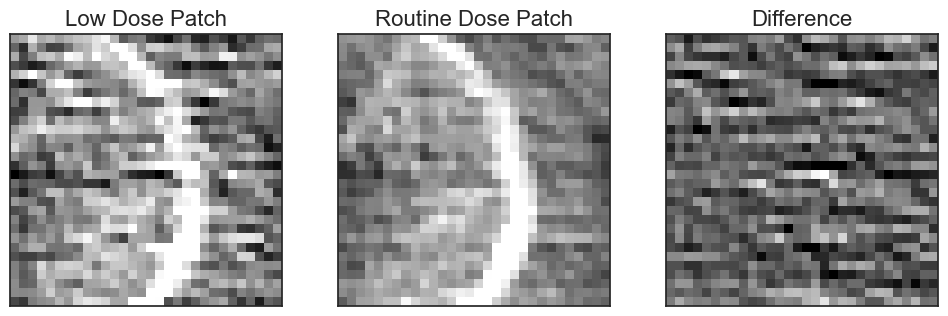

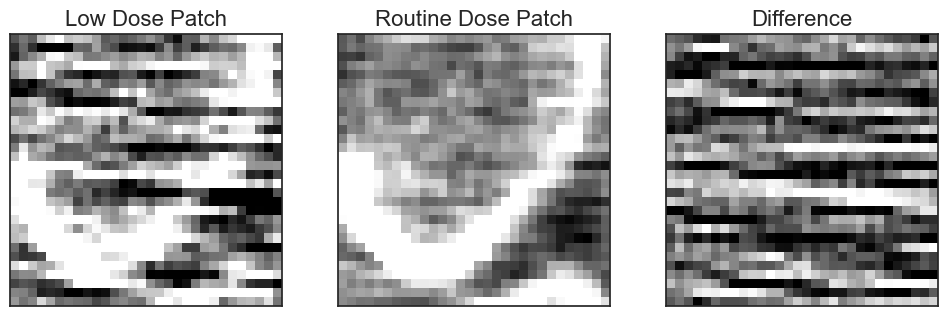

In [5]:
#Cell 5

# Get a few examples of training patches
image_examples = [3, 16, 36]
window = 'soft_tissue'

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Low Dose Patch', fontsize=16)
  ctshow(train_input[nexample, :, :, 0], window=window)

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Routine Dose Patch', fontsize=16)
  ctshow(train_target[nexample, :, :, 0], window=window)
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  ctshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0],
           window=window)

"""## Building Keras model:

CNNs are simply mathematical functions that consist of repeated convolution operations. Each convolutional layer convolves multiple filters (kernels) over the input images. The values used for each filter are free parameters that are adjusted during the training procedure. A simple non-linear activation function is also applied between the convolutional layers.

Provided below is a basic model for CNN denoising containing convolutional layers and ReLU activation layers. Each layer operates on the output of the previous layer.

![](https://drive.google.com/uc?id=1wVJJ1olpxpXSFo32bbFjUZhjHW4uUiiF)


"""

In [6]:
#Cell 6

# This specifies the number of convolutonal layers in the model
n_layers = 6
# This specifies the number of convolutional filters in each convolutional layer
filters = 64
# This specifies the size of the filter in each convolutional layer
kernel_size = (3, 3)
# This specifies the number of pixels the filter translates at each step
strides = (1, 1)
# This specifies the non-linear function applied after each convolutionaly layer
activation = 'relu'

# This function builds the model according to the parameters set above
def build_model():

    # The input tensor image can have arbitrary spatial extent, but just
    # one channel for the grayscale CT images
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')

    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)

    # This loop adds each convolutional layer
    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)
    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)

    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model


denoising_model = build_model()
denoising_model.summary()

Model: "CT_denoiser"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_CT_images (InputLayer  [(None, None, None, 1)]  0         
 )                                                               
                                                                 
 normalization (Lambda)      (None, None, None, 1)     0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 activation (Activation)     (None, None, None, 64)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 activation_1 (Activation)   (None, None, None, 64)    0         
                                                       

## Optimization: Training the network
Take a moment to appreciate the number of trainable parameters listed in the model summary above. These parameters start off randomly initialized and must be optimized to perform a denoising task.
It is worth noting that this denoising task is ill-posed. We should not expect to reconstruct the signal exactly, but we can make a prediction that agrees with the observed noisy data and prior knowledge. During optimization, we aim to have the CNN encode meaningful prior knowledge from many training examples into the predictions.
For this part of the tutorial, the CNN parameters will be optimized with one goal in mind: to minimize the mean-squared-error (MSE) difference between the CNN output images and the low-noise target images.
We can train the model provided the datasets we previously loaded. When running on Google Colab, you will want to utilize a GPU for this optimization procedure. Click **Runtime** above, then **Change Runtime Type** in the drop down menu, finally select **GPU** under hardware accelerator. It should take the GPU under three minutes to train the model with default parameters.

 %% [markdown] make data augmentation

In [7]:
from pathlib import Path
noise_patch_dir = Path('noise_patches')
noise_patch_dict = {f.stem: np.load(f) for f in noise_patch_dir.glob('*.npy')}
print(noise_patch_dict.keys())
noise_patches = np.concatenate(list(noise_patch_dict.values()))
noise_patches.shape

dict_keys(['diameter112mm', 'diameter131mm', 'diameter151mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter292mm', 'diameter350mm'])


(480000, 30, 30)

In [8]:
def augment(image_label, seed, max_noise=1):
  image, label = image_label
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))][:,:,None]
  noise_lambda = tf.random.uniform([1], minval=0, maxval=max_noise)

  add_noise = tf.random.uniform([1], minval=0, maxval=1) > 0.5
  if add_noise:
    image = image + noise_lambda[0]*noise_patch
  return image, label

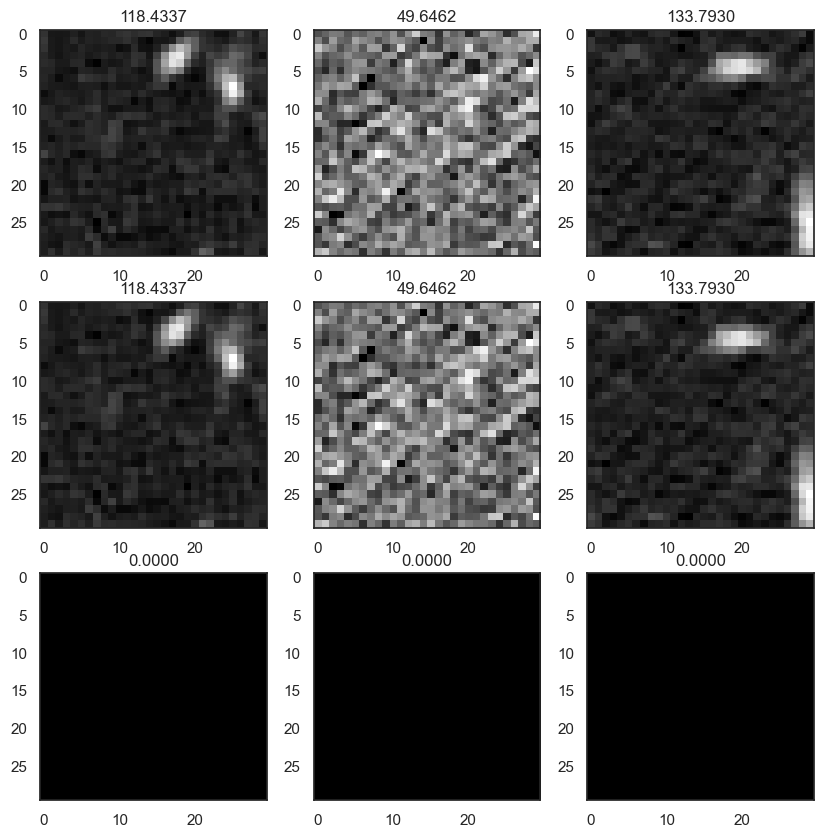

In [9]:
batch_size = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image[0], label[0]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    img = np.array(images[i])
    # aug_image = augment((img, labels[i]), [0, 0])[0]
    aug_image = f((img, labels[i]), [0, 0])[0]

    axs[0, i].imshow(img[:,:,0], cmap='gray')
    axs[0, i].set_title(f'{img.std():0.4f}')
    axs[1, i].imshow(aug_image[:,:,0], cmap='gray')
    axs[1, i].set_title(f'{np.array(aug_image).std():0.4f}')
    diff = aug_image - img
    axs[2, i].imshow(diff[:,:,0], cmap='gray')
    axs[2, i].set_title(f'{np.array(diff).std():0.4f}')

In [10]:
augment_training = True

train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

denoising_model = build_model()
learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)
denoising_model.compile(optimizer=optimizer, loss='mse')

# This sets the number of iterations through the training data
epochs = 15

# This sets the number of images patches used to calcualte a single
# parameter update.
batch_size = 32

# This is a scaling factor that affects the magnitude of each optimization step
learning_rate = 0.0001

# The optimizer manages how the parameters are updated from each gradient
# calculation
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)


# As the training progresses, we'll monitor network output and performance
# metrics
progress_example = 2
buffer = 128
progress_ims = []

AUTOTUNE = tf.data.AUTOTUNE

def train(loss_function, model, augment_training=False):

    train_ds = (
        train_dataset
        .map(f, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    ) if augment_training else (
        train_dataset
       .prefetch(AUTOTUNE)
    )
    model.compile(optimizer=optimizer, loss=loss_function)

    # As the training progresses, we'll monitor network output and performance
    # metrics. Some related variables are initialized here
    example_input = test_input[[3], ...]
    edge_buffer = 128
    progress_ims = []
    progress_val = []

    for epoch in range(epochs):

      # Evaluate model on reserved data
      val_loss = model.evaluate(val_input, val_target)
      example_output = model.predict(example_input)
      example_img = example_output[0, edge_buffer:-edge_buffer,
                                edge_buffer:-edge_buffer, 0]
      progress_ims.append(example_img)
      progress_val.append(val_loss)

      # Update model weights using training data
      istart = 0
      while istart < (len(train_input) - batch_size):
      #     x = train_input[istart:istart + batch_size]
      #     y = train_target[istart:istart + batch_size]
        for x, y in train_ds.take(1):
            model.train_on_batch(x=x, y=y)
        istart += batch_size

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val


# Now run the training fuction to obtain the trained model and performance at
# intermediate steps
for augment_training in [True, False]:
  denoising_model = build_model()
  denoising_model.compile(optimizer=optimizer, loss='mse')
  print(f'Running augmented training: {augment_training}')
  denoising_model, progress_ims, progress_val = train(loss_function='mse', model=denoising_model, augment_training=augment_training)

  save_name = 'models/simple_cnn_denoiser_augmented' if augment_training else 'models/simple_cnn_denoiser'
  tf.keras.models.save_model(denoising_model, save_name)

c:\Users\bnel1\Dev\PediatricCTSizeAugmentation\.venv\PedsDataAug\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Running augmented training: True
1/1 [==============================] - 0s 212ms/step
Training phase complete.


INFO:tensorflow:Assets written to: models/simple_cnn_denoiser_augmented\assets


INFO:tensorflow:Assets written to: models/simple_cnn_denoiser_augmented\assets


Running augmented training: False
1/1 [==============================] - 0s 123ms/step
Training phase complete.


INFO:tensorflow:Assets written to: models/simple_cnn_denoiser\assets


INFO:tensorflow:Assets written to: models/simple_cnn_denoiser\assets


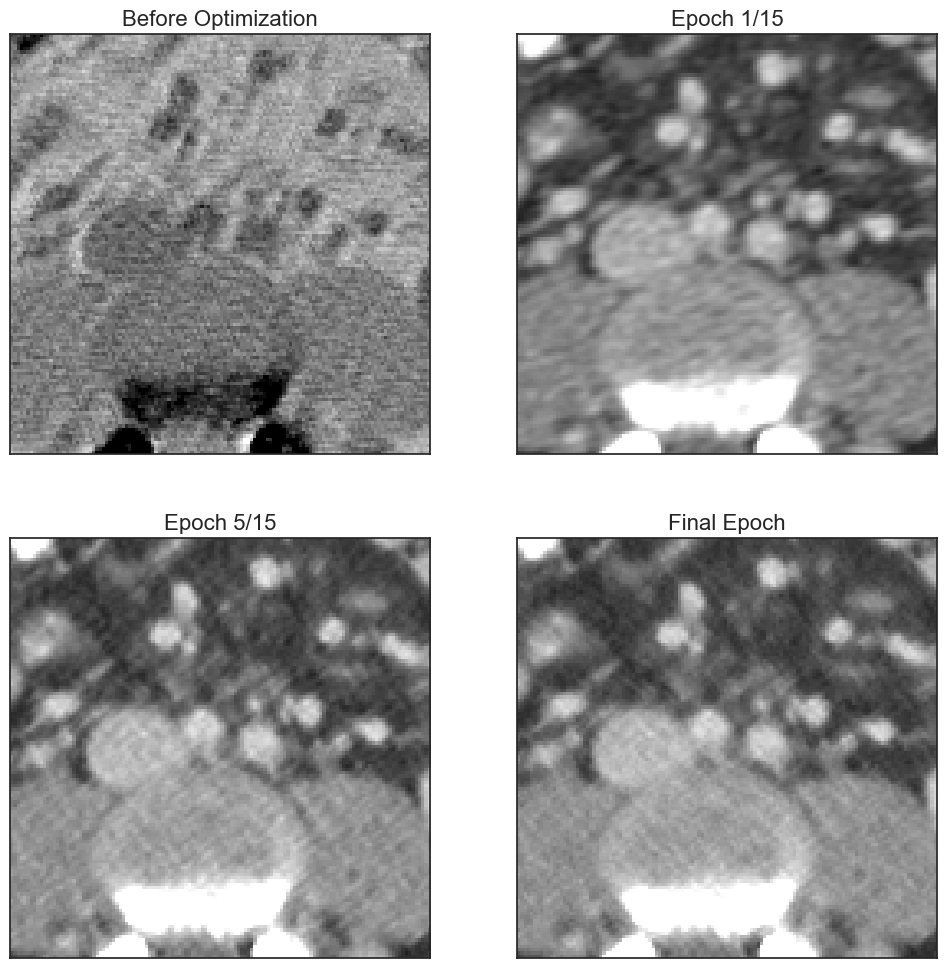

In [11]:
#Cell 8

# Here we show some example images from different epochs in the training
# procedure.

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title('Before Optimization', fontsize=16)
ctshow(progress_ims[0, :, :], window='variable')

plt.subplot(2, 2, 2)
plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
ctshow(progress_ims[1, :, :], window='soft_tissue')

plt.subplot(2, 2, 3)
plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
ctshow(progress_ims[5, :, :], window='soft_tissue')

plt.subplot(2, 2, 4)
plt.title('Final Epoch', fontsize=16)
ctshow(progress_ims[-1, :, :], window='soft_tissue')

In [12]:
"""### Inference: Testing the network

Now that the network is fully trained, we can apply to our CNN in inference mode to the reserved testing data to check the performance. Since all CNN parameters are fixed at this point, the processing time for this phase is typically very fast.

Here we include a comparison with a Gaussian smoothing filter. Notice that the CNN is able to better maintain feature resolution relative to the Gaussian filter. The improvment is most notable at high contrast boundaries.
"""

'### Inference: Testing the network\n\nNow that the network is fully trained, we can apply to our CNN in inference mode to the reserved testing data to check the performance. Since all CNN parameters are fixed at this point, the processing time for this phase is typically very fast.\n\nHere we include a comparison with a Gaussian smoothing filter. Notice that the CNN is able to better maintain feature resolution relative to the Gaussian filter. The improvment is most notable at high contrast boundaries.\n'